In [1]:
%reload_ext blackcellmagic
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qflow.wavefunctions import (
    JastrowMcMillian,
    JastrowPade,
    JastrowOrion,
    SimpleGaussian,
    WavefunctionProduct,
    FixedWavefunction,
    Dnn,
    SumPooling,
)
from qflow.wavefunctions.nn.layers import DenseLayer
from qflow.wavefunctions.nn.activations import sigmoid, tanh, relu, identity, exponential

from qflow.hamiltonians import LennardJones, HDFHE2

from qflow.samplers import BoxImportanceSampler
from qflow.optimizers import AdamOptimizer, SgdOptimizer
from qflow.training import train, EnergyCallback, SymmetryCallback, ParameterCallback
from qflow.statistics import compute_statistics_for_series
from qflow import DistanceCache

def plot_training(energies, symmetries, parameters):
    fig, (eax, sax, pax) = plt.subplots(ncols=3, figsize=(16, 4))
    eax.plot(energies, label=r"$\langle E_L\rangle$ [a.u]")
    sax.semilogx(symmetries, label=r"$S(\Psi)$")
    pax.semilogx(parameters)
    eax.legend()
    sax.legend()

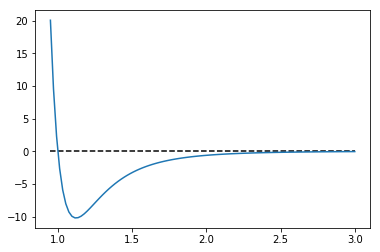

In [7]:
H = LennardJones()
x = np.linspace(.95, 3, 100)
plt.plot(x, [H.internal_potential(np.array([[0, 0], [1, 0]])*x_) for x_ in x])
plt.hlines(0, min(x), max(x), linestyles='dashed')

In [8]:
rho = 0.0196  # Å^-3
P, D = 6, 3  # Particles, dimensions
L = (P / rho)**(1/3) * 10
system = np.empty((P, D))
L

67.39562829023619

In [9]:
#with DistanceCache(system):
psi = JastrowMcMillian(5, 2.51)
psi_sampler = BoxImportanceSampler(system, psi, L, 0.1)
psi_sampler.thermalize(10000)
s = psi_sampler.next_configuration()
print(psi_sampler.acceptance_rate)
print(s)
print(H.internal_potential(s))
print(H.kinetic_energy(s, psi))
print(H.local_energy(s, psi))

0.0
[[67.02297926 66.86272813  0.18281976]
 [ 0.57960462 66.95993091  0.11097223]
 [66.93790921 67.34771211  0.58736403]
 [66.99335251 67.3314978   0.28338138]
 [67.30722932 67.13566336  0.16548176]
 [ 0.07560372  0.41636254 67.28572717]]
59661087.90897225
-339652158462.0337
-339592497374.1247


In [10]:
psi_energies = EnergyCallback(samples=5000, verbose=True)
psi_symmetries = SymmetryCallback(samples=100)
psi_parameters = ParameterCallback()

with DistanceCache(system, L):
    train(
        psi,
        H,
        psi_sampler,
        iters=15000,
        samples=1000,
        gamma=0,
        optimizer=AdamOptimizer(len(psi.parameters)),
        call_backs=(psi_energies, psi_symmetries, psi_parameters),
    )
plot_training(np.array(psi_energies)/P, psi_symmetries, psi_parameters)


EnergyCallback(iter=0): -1462874132474.7078
EnergyCallback(iter=150): -1505809462691.0002
EnergyCallback(iter=300): -1438451541297.9229
EnergyCallback(iter=450): -1433860412747.0625
EnergyCallback(iter=600): -1498459482259.243
EnergyCallback(iter=750): -1606118112227.2236
EnergyCallback(iter=900): -1457368383713.058
EnergyCallback(iter=1050): -1413537401202.0637
EnergyCallback(iter=1200): -1388664470432.7417
EnergyCallback(iter=1350): -1326066314286.6816


KeyboardInterrupt: 